# Importy

In [21]:
import os
import sys
#!{sys.executable} -m pip install opencv-python  
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.models import resnet18, ResNet18_Weights
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Kodowania map głębi

## Pseudokolorowanie map głębi (Colormap)

Mapowanie wartości głębi do przestrzeni kolorów (JET), w celu uzyskania 3-kanałowej reprezentacji
umożliwiającej użycie sieci CNN z transfer learningiem.

In [ ]:
def depth_to_colormap(depth_img):
    if len(depth_img.shape) > 2:
        depth_img = cv2.cvtColor(depth_img, cv2.COLOR_BGR2GRAY)
    depth_norm = cv2.normalize(depth_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    return cv2.applyColorMap(depth_norm, cv2.COLORMAP_JET)

## Normalne powierzchni (Surface Normals)

Reprezentacja głębi poprzez wektory normalne (Nx, Ny, Nz), obliczane na podstawie gradientów
mapy głębi. Kodowanie 3-kanałowe zachowujące informacje o geometrii sceny.

In [ ]:
def depth_to_normals(depth_img):
    if len(depth_img.shape) > 2:
        depth_img = cv2.cvtColor(depth_img, cv2.COLOR_BGR2GRAY)
    depth_float = depth_img.astype(np.float32)
    zx = cv2.Sobel(depth_float, cv2.CV_64F, 1, 0, ksize=5)
    zy = cv2.Sobel(depth_float, cv2.CV_64F, 0, 1, ksize=5)
    normal = np.dstack((-zx, -zy, np.ones_like(depth_float)))
    n = np.linalg.norm(normal, axis=2, keepdims=True)
    normal = np.divide(normal, n, out=np.zeros_like(normal), where=n!=0)
    return ((normal + 1) * 127.5).astype(np.uint8)

## Kodowanie HHA (Height, Disparity, Angle)

Trójkanałowa reprezentacja map głębi:
- **H** – wysokość nad podłożem,
- **D** – disparity (odwrotność głębi),
- **A** – kąt względem kierunku grawitacji.

Kodowanie często stosowane w literaturze do analizy scen 3D i detekcji aktywności.


In [ ]:
def depth_to_hha(depth_img):
    if len(depth_img.shape) > 2:
        depth_img = cv2.cvtColor(depth_img, cv2.COLOR_BGR2GRAY)
    
    depth_float = depth_img.astype(np.float32)
    
    # Height above ground (H) - normalizujemy od 0 do 255
    H = cv2.normalize(depth_float, None, 0, 255, cv2.NORM_MINMAX)
    
    # Angle with gravity (A) - kąt gradientu
    gx = cv2.Sobel(depth_float, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(depth_float, cv2.CV_32F, 0, 1, ksize=3)
    angle = np.arctan2(gy, gx)
    angle_norm = cv2.normalize(angle, None, 0, 255, cv2.NORM_MINMAX)
    
    # Disparity (D) - odwrotność wartości depth
    disparity = 1.0 / (depth_float + 1e-5)
    disparity_norm = cv2.normalize(disparity, None, 0, 255, cv2.NORM_MINMAX)
    
    hha = cv2.merge([disparity_norm.astype(np.uint8),
                     H.astype(np.uint8),
                     angle_norm.astype(np.uint8)])
    return hha


## Klasa `DepthFallDataset` – przygotowanie danych wejściowych

Klasa datasetu odpowiedzialna za:
- wczytywanie map głębi z dwóch folderów (upadki / czynności ADL),
- przypisanie etykiet klas:
  - `1` – upadek (fall),
  - `0` – brak upadku (ADL),
- konwersję map głębi do wybranego kodowania:
  - raw depth,
  - colormap,
  - normalne powierzchni,
  - HHA,
- przygotowanie danych w formacie zgodnym z sieciami CNN (3 kanały).


In [23]:
class DepthFallDataset(Dataset):
    def __init__(self, fall_dir, adl_dir, encoding='raw', transform=None):
        self.fall_dir = fall_dir
        self.adl_dir = adl_dir
        self.encoding = encoding
        self.transform = transform
        
        # Lista plików
        self.fall_images = [os.path.join(fall_dir, f) for f in os.listdir(fall_dir) if f.endswith(('.png','.jpg'))]
        self.adl_images  = [os.path.join(adl_dir, f)  for f in os.listdir(adl_dir)  if f.endswith(('.png','.jpg'))]
        
        self.images = self.fall_images + self.adl_images
        self.labels = [1]*len(self.fall_images) + [0]*len(self.adl_images)

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        if self.encoding == 'colormap':
            img = depth_to_colormap(img)
        elif self.encoding == 'normals':
            img = depth_to_normals(img)
        elif self.encoding == 'hha':
            img = depth_to_hha(img)
        else:  # raw
            img = cv2.merge([img,img,img])

        
        if self.transform:
            img = self.transform(img)
            
        return img, self.labels[idx]

## Struktura zbioru danych

Dane zostały podzielone na dwa niezależne zestawy:
- **zbiór treningowy** – wykorzystywany do uczenia modelu,
- **zbiór walidacyjny** – pochodzący z innych sekwencji, służący do oceny
  zdolności generalizacji modelu.

Każdy zbiór składa się z dwóch folderów:
- `fall` – sekwencje zawierające upadek,
- `adl` – sekwencje bez upadku (Activities of Daily Living).

## Parametry treningu

Zdefiniowano podstawowe hiperparametry wykorzystywane
we wszystkich eksperymentach, aby zapewnić porównywalność wyników
dla różnych kodowań map głębi.



In [ ]:
DATA_FALL = 'data/fall'    # folder z upadkami
DATA_ADL  = 'data/adl'     # folder bez upadków

DATA_FALL_VAL = 'data/fall-val'  # folder z upadkami do walidacji
DATA_ADL_VAL  = 'data/adl-val'   # folder bez upadków do walidacji


BATCH_SIZE = 8
EPOCHS = 5
IMG_SIZE = 224
LR = 1e-3


## Transformacje obrazów głębi

Obrazy głębi są:
- skalowane do rozmiaru 224×224 (wymaganego przez ResNet),
- konwertowane do tensora,
- normalizowane statystykami zbioru ImageNet, co umożliwia
  skuteczne wykorzystanie transfer learningu.

Opcjonalnie można włączyć augmentację danych (rotacje, odbicia),
jednak w prezentowanych eksperymentach została ona wyłączona,
aby skupić się wyłącznie na wpływie kodowania głębi.


In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),

    # DODANIE ROTACJI
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(10),
    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

##  Ewaluacja modelu

Do oceny jakości działania modelu zastosowano standardowe metryki
klasyfikacji binarnej, obliczane na zbiorze walidacyjnym.

Model jest przełączany w tryb ewaluacji (`model.eval()`), a obliczenia
wykonywane są bez śledzenia gradientów, co zmniejsza zużycie pamięci
i przyspiesza inferencję.

Dla każdej próbki:
- wyznaczana jest klasa o największym prawdopodobieństwie (argmax),
- zapisywane są etykiety rzeczywiste oraz przewidywane.

Na tej podstawie obliczane są następujące miary jakości:

- **Accuracy** – ogólny odsetek poprawnych klasyfikacji,
- **Precision** – precyzja detekcji upadków (odporna na fałszywe alarmy),
- **Recall** – czułość detekcji upadków (kluczowa z punktu widzenia bezpieczeństwa),
- **F1-score** – średnia harmoniczna precision i recall,
- **Confusion Matrix** – macierz pomyłek dla klas:
  - 0 – aktywności codzienne (ADL),
  - 1 – upadki.

Zastosowanie parametru `zero_division=0` zapobiega błędom w sytuacjach,
gdy model nie przewidzi jednej z klas, co jest istotne przy niezbalansowanych danych.

Zestawienie powyższych metryk umożliwia kompleksową ocenę skuteczności
modelu oraz porównanie różnych wariantów kodowania map głębi.


In [25]:
def evaluate_model(model, loader, device):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device).long()
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    return acc, prec, rec, f1, cm

##  Uruchamianie eksperymentu dla wybranego kodowania głębi

W tej sekcji zdefiniowano funkcję `run_experiment`, która realizuje pełny
pipeline eksperymentalny dla danego wariantu kodowania map głębi
(raw, colormap, normals, HHA).

Eksperyment obejmuje:
- przygotowanie zbioru treningowego i walidacyjnego,
- inicjalizację i trenowanie modelu CNN,
- ewaluację jakości klasyfikacji na zbiorze walidacyjnym,
- wizualizację macierzy pomyłek.

###  Konfiguracja urządzenia obliczeniowego

Model trenowany jest z wykorzystaniem GPU (CUDA), jeśli jest dostępne.
W przeciwnym razie obliczenia wykonywane są na CPU.

###  Przygotowanie zbiorów danych

Dla wybranego kodowania głębi tworzony jest:
- zbiór treningowy (fall / ADL),
- zbiór walidacyjny (fall-val / adl-val).

Dane ładowane są przy użyciu klasy `DepthFallDataset` oraz `DataLoader`,
z zachowaniem losowego mieszania próbek w zbiorze treningowym.

###  Architektura modelu

W eksperymencie wykorzystano sieć **ResNet-18** z wagami wstępnie
wytrenowanymi na zbiorze ImageNet.

Ostatnia warstwa w pełni połączona została zastąpiona warstwą
dwuklasową, dostosowaną do zadania klasyfikacji:
- 0 – aktywności codzienne (ADL),
- 1 – upadki.

###  Proces trenowania

Model trenowany jest przez określoną liczbę epok z użyciem:
- funkcji straty **CrossEntropyLoss**,
- optymalizatora **Adam**.

Podczas każdej epoki obliczana jest średnia wartość straty treningowej,
która pozwala monitorować proces uczenia.

###  Ewaluacja na zbiorze walidacyjnym

Po zakończeniu treningu model oceniany jest na zbiorze walidacyjnym.
Obliczane metryki obejmują:
- accuracy,
- precision,
- recall,
- F1-score,
- macierz pomyłek.

Dodatkowo macierz pomyłek jest wizualizowana w formie wykresu,
co ułatwia analizę błędów klasyfikacji.

### Zwracane wyniki eksperymentu

Funkcja `run_experiment` zwraca:
- wytrenowany model,
- loader treningowy,
- loader walidacyjny,
- zestaw metryk jakości (accuracy, precision, recall, F1-score, confusion matrix),

co umożliwia dalsze porównania pomiędzy różnymi wariantami kodowania głębi.


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def run_experiment(encoding_name):
    print(f"\n--- Eksperyment: {encoding_name} ---")
    
    dataset = DepthFallDataset(DATA_FALL, DATA_ADL, encoding=encoding_name, transform=transform)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    # Loader walidacyjny
    val_dataset = DepthFallDataset(DATA_FALL_VAL, DATA_ADL_VAL, encoding=encoding_name, transform=transform)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    
    # Model ResNet18
    model = resnet18(weights=ResNet18_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, 2)
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    
    # Trening
    model.train()
    for epoch in range(EPOCHS):
        running_loss = 0
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device).long()
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {running_loss/len(loader):.4f}")
    
    # Ewaluacja
   # Ewaluacja na walidacji
    acc, prec, rec, f1, cm = evaluate_model(model, val_loader, device)
    print(f"\nValidation Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
    print("Validation Confusion Matrix:\n", cm)

    disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
    disp.plot(cmap=plt.cm.Blues)
    #plt.show()
    
    return model, loader, val_loader, (acc, prec, rec, f1, cm)

##  Porównanie różnych kodowań map głębi

W tej sekcji przeprowadzane są eksperymenty dla kilku wariantów
kodowania map głębi:

- **raw** – surowa mapa głębi,
- **colormap** – mapa głębi zakodowana kolorem,
- **normals** – mapy normalnych powierzchni,
- **HHA** – kodowanie wysokości, kąta z grawitacją i dysparycji.

Dla każdego kodowania:
- trenowany jest osobny model CNN,
- wykonywana jest ewaluacja na tym samym zbiorze walidacyjnym,
- zapisywane są metryki jakości klasyfikacji
  (accuracy, precision, recall, F1-score oraz macierz pomyłek).

Wyniki zapisywane są w słowniku `results`, co umożliwia ich dalsze
zestawienie w formie tabel i wykresów porównawczych.



--- Eksperyment: raw ---
Epoch 1/5 | Loss: 0.0920
Epoch 2/5 | Loss: 0.0577
Epoch 3/5 | Loss: 0.0352
Epoch 4/5 | Loss: 0.0256
Epoch 5/5 | Loss: 0.0002

Validation Accuracy: 1.0000 | Precision: 1.0000 | Recall: 1.0000 | F1: 1.0000
Validation Confusion Matrix:
 [[605   0]
 [  0 595]]

--- Eksperyment: colormap ---
Epoch 1/5 | Loss: 0.0676
Epoch 2/5 | Loss: 0.0188
Epoch 3/5 | Loss: 0.0553
Epoch 4/5 | Loss: 0.0551
Epoch 5/5 | Loss: 0.0244

Validation Accuracy: 0.6458 | Precision: 0.5833 | Recall: 1.0000 | F1: 0.7368
Validation Confusion Matrix:
 [[180 425]
 [  0 595]]

--- Eksperyment: normals ---
Epoch 1/5 | Loss: 0.0648
Epoch 2/5 | Loss: 0.0004
Epoch 3/5 | Loss: 0.0558
Epoch 4/5 | Loss: 0.0672
Epoch 5/5 | Loss: 0.0218

Validation Accuracy: 1.0000 | Precision: 1.0000 | Recall: 1.0000 | F1: 1.0000
Validation Confusion Matrix:
 [[605   0]
 [  0 595]]

--- Eksperyment: hha ---
Epoch 1/5 | Loss: 0.0750
Epoch 2/5 | Loss: 0.0016
Epoch 3/5 | Loss: 0.0003
Epoch 4/5 | Loss: 0.0004
Epoch 5/5 | Loss

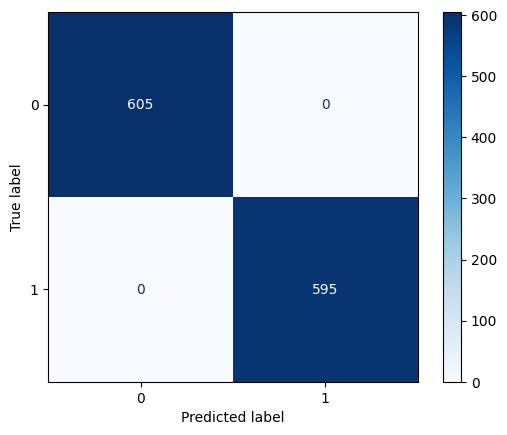

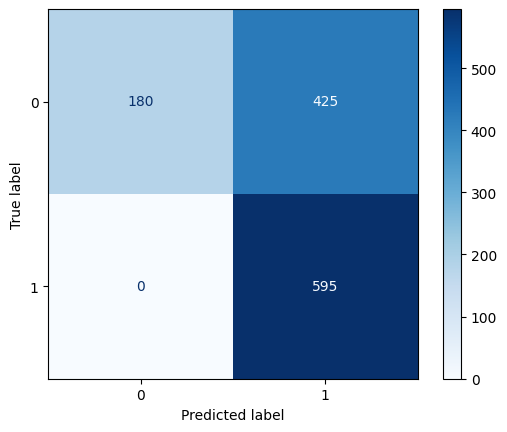

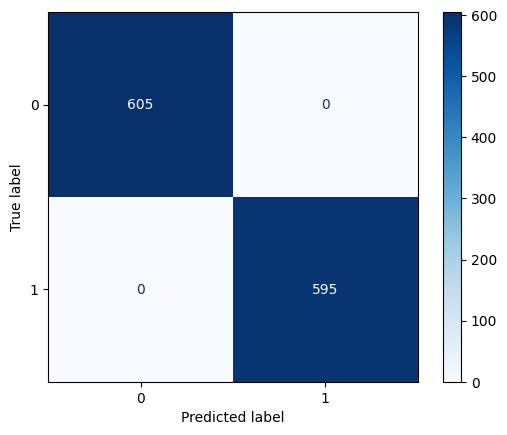

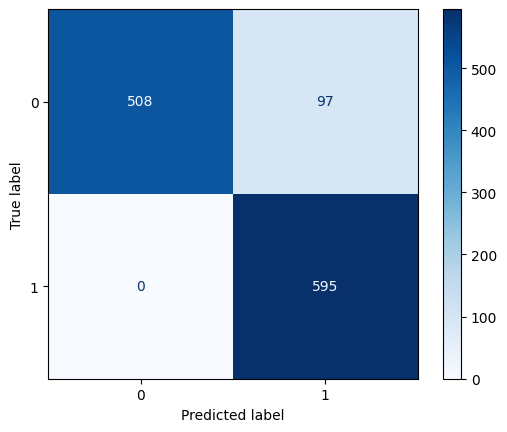

In [27]:
results = {}
for encoding in ['raw','colormap','normals','hha']:
    model, loader, val_loader, metrics = run_experiment(encoding)
    results[encoding] = metrics


##  Zestawienie wyników ilościowych

W tej sekcji przedstawiono porównanie skuteczności klasyfikacji upadków
dla różnych metod kodowania map głębi.

Dla każdego wariantu (`raw`, `colormap`, `normals`, `HHA`) zestawiono
następujące metryki obliczone na zbiorze walidacyjnym:

- **Accuracy** – ogólna skuteczność klasyfikacji,
- **Precision** – precyzja wykrywania upadków (odporność na fałszywe alarmy),
- **Recall** – czułość wykrywania upadków,
- **F1-score** – średnia harmoniczna precision i recall.

Wyniki zostały zaprezentowane:
- w formie **tabeli porównawczej**,  
- oraz na **wykresie słupkowym**, umożliwiającym łatwą wizualną analizę
  różnic pomiędzy poszczególnymi kodowaniami głębi.


,Accuracy,Precision,Recall,F1-score
Encoding,,,,
raw,1.000000,1.000000,1.0,1.000000
colormap,0.645833,0.583333,1.0,0.736842
normals,1.000000,1.000000,1.0,1.000000
hha,0.919167,0.859827,1.0,0.924631


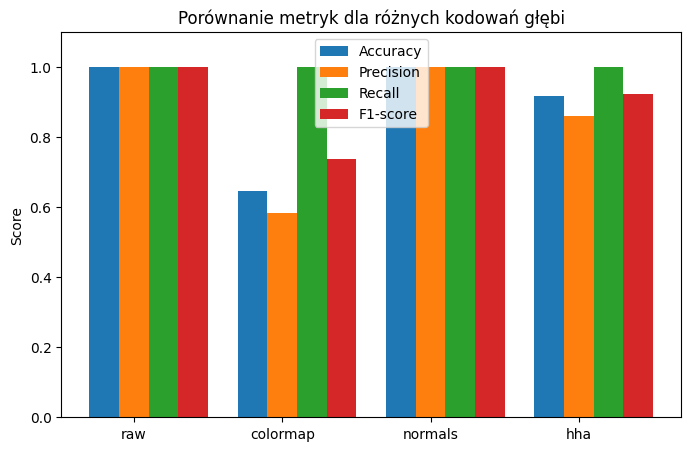

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Przygotowanie danych do tabeli
data = []
for enc, metrics in results.items():
    acc, prec, rec, f1, cm = metrics
    data.append({
        'Encoding': enc,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-score': f1
    })

# Tabela porównawcza
df_results = pd.DataFrame(data)
df_results = df_results.set_index('Encoding')
display(df_results)

# Wykres słupkowy
plt.figure(figsize=(8,5))
bar_width = 0.2
x = np.arange(len(df_results.index))

plt.bar(x - bar_width, df_results['Accuracy'], width=bar_width, label='Accuracy')
plt.bar(x, df_results['Precision'], width=bar_width, label='Precision')
plt.bar(x + bar_width, df_results['Recall'], width=bar_width, label='Recall')
plt.bar(x + 2*bar_width, df_results['F1-score'], width=bar_width, label='F1-score')

plt.xticks(x, df_results.index)
plt.ylabel('Score')
plt.title('Porównanie metryk dla różnych kodowań głębi')
plt.ylim(0,1.1)
plt.legend()
plt.show()


| Kodowanie    | Accuracy | Precision | Recall | F1-score | Uwagi                                                                                    |
| ------------ | -------- | --------- | ------ | -------- | ---------------------------------------------------------------------------------------- |
| **raw**      | 1.000    | 1.000     | 1.000  | 1.000    | Perfekcyjna klasyfikacja na zbiorze walidacyjnym; możliwe dopasowanie do specyfiki scen  |
| **colormap** | 0.646    | 0.583     | 1.000  | 0.737    | Dobra wykrywalność upadków, ale duża liczba fałszywych alarmów (false positives)         |
| **normals**  | 1.000    | 1.000     | 1.000  | 1.000    | Bardzo wysoka skuteczność; podobnie jak raw możliwa ograniczona zdolność generalizacji   |
| **HHA**      | 0.919    | 0.860     | 1.000  | 0.925    | Najbardziej zrównoważone wyniki – wysoka skuteczność przy zachowaniu błędów klasyfikacji |

## Wnioski

- Wszystkie modele osiągnęły Recall = 1.0, co oznacza, że żaden rzeczywisty upadek nie został pominięty – jest to cecha pożądana w systemach bezpieczeństwa.
- Kodowania raw depth oraz surface normals osiągnęły perfekcyjne wyniki, co może wskazywać na:

    - dużą spójność między danymi treningowymi i walidacyjnymi,

    - możliwe nadmierne dopasowanie (overfitting) do konkretnych scen lub tła.
- Colormap wykazuje znacznie gorszą precyzję, co sugeruje, że pseudokolorowanie wprowadza artefakty utrudniające poprawną klasyfikację aktywności ADL.
- HHA zapewnia najlepszy kompromis pomiędzy wysoką skutecznością a zdolnością generalizacji – model popełnia błędy, ale nie „uczy się na pamięć” danych walidacyjnych.

## Rekomendacje dalszych prac

- Zwiększyć różnorodność danych walidacyjnych (inne sekwencje, inne osoby, inne układy scen).
- Zastosować augmentację danych głębi (szum, przesunięcia, skalowanie).
- Sprawdzić stabilność wyników przy innym podziale danych lub walidacji krzyżowej.
- Przeanalizować wizualnie przykładowe sekwencje, w których:
    - raw / normals klasyfikują poprawnie,
    - colormap generuje fałszywe alarmy.
- Rozważyć agregację decyzji z wielu klatek (klasyfikacja sekwencji zamiast pojedynczych obrazów).